In [1]:
# fd = pd.read_csv('data/sources/MSPD_SumSecty.csv',index_col='Record Date').iloc[:,:5]
# fd=fd[fd['Security Type Description']=='Marketable'].iloc[:,[1,-1]]

# bills = fd[fd['Security Class Description']=='Bills'].iloc[:,-1]
# notes = fd[fd['Security Class Description']=='Notes'].iloc[:,-1]
# bonds = fd[fd['Security Class Description']=='Bonds'].iloc[:,-1]

# fd = pd.concat([bills,notes,bonds],axis=1,)
# fd.columns = ['Bills','Notes','Bonds']
# fd['All'] = fd['Bills']+fd['Notes']+fd['Bonds']
# fd = fd / 1000000

https://fiscaldata.treasury.gov/static-data/downloads/zip/899d023b5748167dfd03db20dd39b2502bcbd9eb85d9df3c27d8653f8d91ad33/HstDebt_17900101_20210930.zip

In [140]:
import datetime as dt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from stargazer.stargazer import Stargazer
from statsmodels import tsa

import pandas_datareader as pdr
import investpy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import quandl
quandl.ApiConfig.api_key = 'p6a-5ZygiQRAyS5B3_oL'

plt.rcParams['figure.figsize'] = [15, 9]
plt.rcParams['figure.dpi'] = 140

In [141]:
def align_y_axis(ax1, ax2, minresax1, minresax2):
    """ Sets tick marks of twinx axes to line up with 7 total tick marks

    ax1 and ax2 are matplotlib axes
    Spacing between tick marks will be a factor of minresax1 and minresax2"""

    ax1ylims = ax1.get_ybound()
    ax2ylims = ax2.get_ybound()
    ax1factor = minresax1 * 7
    ax2factor = minresax2 * 7
    ax1.set_yticks(np.linspace(ax1ylims[0],
                               ax1ylims[1]+(ax1factor -
                               (ax1ylims[1]-ax1ylims[0]) % ax1factor) %
                               ax1factor,
                               8).round(2))
    ax2.set_yticks(np.linspace(ax2ylims[0],
                               ax2ylims[1]+(ax2factor -
                               (ax2ylims[1]-ax2ylims[0]) % ax2factor) %
                               ax2factor,
                               8).round(2))

In [142]:
start_date = '2008-01-02'
end_date = '2021-12-31' 

In [175]:
ust = quandl.get("USTREASURY/YIELD")

In [143]:
# [FRED] Assets: Securities Held Outright: U.S. Treasury Securities: All: Wednesday Level
treast =  pd.read_csv('data/FRED_TREAST.csv',index_col='DATE') #in trill

# [FRED] Overnight Reverse Repurchase Agreements: Treasury Securities Sold by the Federal Reserve in the Temporary Open Market Operations
rrp = pd.read_csv('data/FRED_RRPONTSYD.csv',index_col='DATE') # in trill

# [NYFED] Broad General Collateral Rate
bgcr = pd.read_csv('data/NYFED_BGCR.csv',index_col='date').iloc[:,:7]

# [OFR] GCF Repo Service Average Rate: U.S. Treasury Securities (Preliminary)
ofr = pd.read_csv('data/OFR_REPO-GCF_AR_T-P.csv',index_col='date')

# [DTCC] GCF Repo Index for U.S. Treasury
dtcc = pd.read_csv('data/DTCC_GCF.csv',index_col='Date').iloc[:,1:2]

# [NYFED] Primary Dealer transactions: all UST
pd_transactions = pd.read_csv('data/NYFED_PD_transactions.csv',index_col='date')

# [treasury.gov] US T-bill rates
bills =  pd.read_csv('data/TREASURY_tbills.csv',index_col='Date')

# [FRED (FEDFUNDS)] Effective Fed Funds Rate
fedfunds = pd.read_csv('data/FRED_fedfunds.csv',index_col='DATE')

# [FRED (USDONTD156N)] ON LIBOR USD
on_libor = pd.read_csv('data/FRED_ON_LIBOR.csv',index_col='DATE')

# [FRED (DFEDTARU)] Fed Funds Rate Upper Target
fed_target = pd.read_csv('data/FRED_ffr_target.csv',index_col='DATE')

# [FRED (T10Y2Y)] T10Y2Y Spread
T10Y2Y = pd.read_csv('data/FRED_T10Y2Y.csv',index_col='DATE')

# [NYFED] Repo Fails (PDFTR-USTET)
fails = pd.read_csv('data/NYFED_repo_fails.csv',index_col='Date')

# Goldman Sachs - Collateral permitted to be repledged (in millions)
gs_repledged = pd.read_csv('data/repledged.csv',index_col='Date') / 1000000 # in trills

# All marketable debt of the US (bills+notes+bonds)
debt = pd.read_csv('data/marketable_federal_debt.csv',index_col='Record Date').iloc[:,-1]

# Federal Surplus or Deficit / GDP
deficit_gdp = pdr.DataReader('FYFSGDA188S','fred',start_date)

In [144]:
# EFFR
effr = pd.read_excel('data/EFFR.xlsx',sheet_name='Results',index_col='Effective Date').iloc[:,1:2]

/home/hmrug/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [145]:
# treas15 = pd.read_excel('data/TREAS15.xlsx',index_col='DATE') / 1000000 # in trill
# treas1590 = pd.read_excel('data/TREAS1590.xlsx',index_col='DATE') / 1000000 # in trill
# treas911y = pd.read_excel('data/TREAS911Y.xlsx',index_col='DATE') / 1000000 # in trill
# treas1t5 = pd.read_excel('data/TREAS1T5.xlsx',index_col='DATE') / 1000000 # in trill
# treas5t10 = pd.read_excel('data/TREAS5T10.xlsx',index_col='DATE') / 1000000 # in trill

In [146]:
treast.index = pd.to_datetime(treast.index)
rrp.index = pd.to_datetime(rrp.index)
bgcr.index = pd.to_datetime(bgcr.index)
ofr.index = pd.to_datetime(ofr.index)
dtcc.index = pd.to_datetime(dtcc.index)
pd_transactions.index = pd.to_datetime(pd_transactions.index)
bills.index = pd.to_datetime(bills.index)
on_libor.index = pd.to_datetime(on_libor.index)
fed_target.index = pd.to_datetime(fed_target.index)
T10Y2Y.index = pd.to_datetime(T10Y2Y.index)
fails.index = pd.to_datetime(fails.index)
gs_repledged.index = pd.to_datetime(gs_repledged.index)
debt.index = pd.to_datetime(debt.index)
deficit_gdp.index = pd.to_datetime(deficit_gdp.index)
effr.index = pd.to_datetime(effr.index)

In [147]:
c_spread = pd.concat([dtcc,effr],axis=1).dropna()
c_spread['Collateral Spread'] = c_spread['Rate (%)'] - c_spread['Treasury GCF Repo Rate']

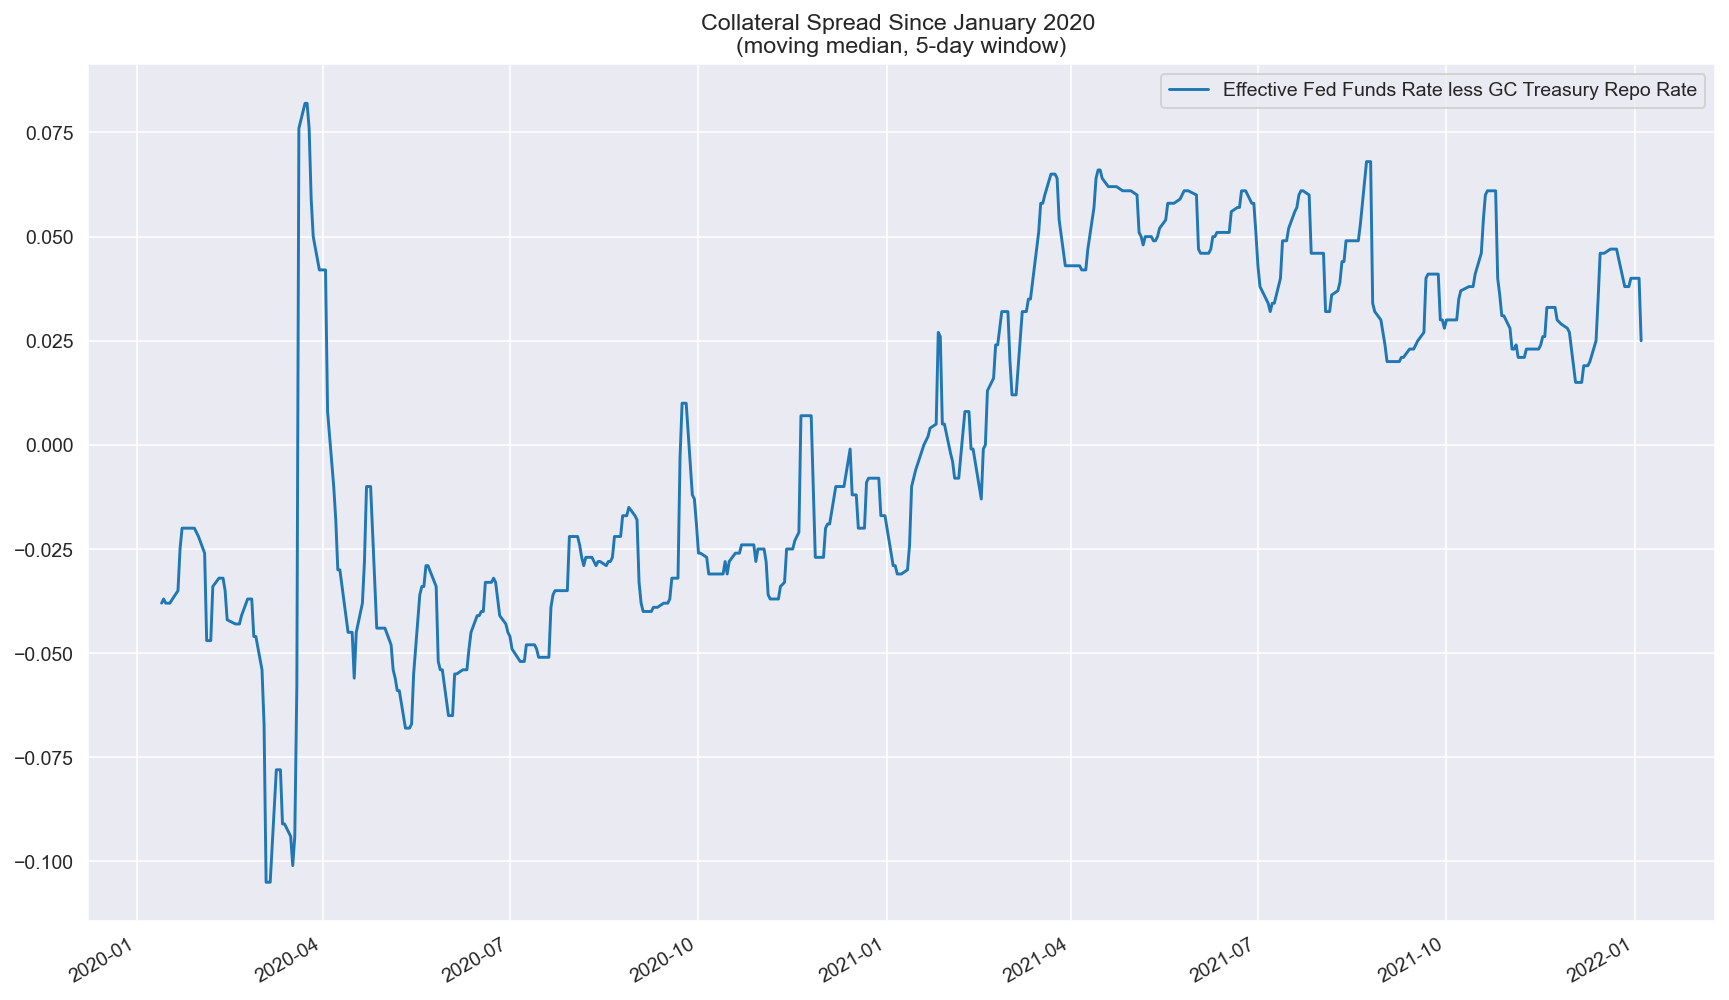

In [149]:
c_spread['Collateral Spread'].tail(500).rolling(5).median().plot()
plt.title('Collateral Spread Since January 2020 \n(moving median, 5-day window)')
plt.legend(['Effective Fed Funds Rate less GC Treasury Repo Rate'])

In [150]:
gs_repledged.sort_index(inplace=True)
gs_repledged = gs_repledged.resample('Q').last()

In [151]:
df1 = pd.concat([dtcc,treast,rrp,gs_repledged,on_libor,T10Y2Y,debt,fed_target],axis=1).loc['2008-01-02':]

df1.index = pd.to_datetime(df1.index)
df1.columns = ['GCF_Repo','TREAST','RRPONTSYD',
               'GS','ONLIBOR','T10Y2Y','Debt','FEDUT']

In [152]:
df1_Q = df1.resample('Q').last()
df1_Q['TREAST/Debt'] = df1_Q['TREAST']/df1_Q['Debt']
df1_Q['RRPONTSYD'].fillna(0,inplace=True)

df1_Qdiff = df1_Q.diff()

In [153]:
df1_Qdiff_names = []
for i in df1_Qdiff.columns:
    i_name = str('D_')+i
    df1_Qdiff_names.append(i_name)
    
df1_Qdiff.columns = df1_Qdiff_names

In [154]:
df1_Qa = pd.concat([df1_Q,df1_Qdiff],axis=1)
df1_Qa['FEDUT-Repo'] = df1_Qa['FEDUT']-df1_Qa['GCF_Repo']
df1_Qa['dummy_RRPONTSYD'] = df1_Qa.eval('RRPONTSYD>0.1')

In [155]:
spec_Q1 = sm.OLS(endog=df1_Qa['D_GCF_Repo'],
               exog=df1_Qa.loc[:,['D_TREAST','D_Debt','D_GS']],
               missing='drop',hasconst=True)
res_Q1 = spec_Q1.fit().summary()

# spec_Q1 = ols('D_GCF_Repo ~ D_TREAST + D_Debt + D_GS + D_RRPONTSYD', data=df1_Qa)
# res_Q1 = spec_Q1g.fit().summary()

In [156]:
res_Q1

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             D_GCF_Repo   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.734
Date:                Wed, 26 Jan 2022   Prob (F-statistic):              0.187
Time:                        21:35:37   Log-Likelihood:                -50.556
No. Observations:                  54   AIC:                             107.1
Df Residuals:                      51   BIC:                             113.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D_TREAST      -1.1263      0.670     -1.680      0.099      -2.472       0.219
D_Debt         0.3053      0.308      0.992      0.326      -0.313       0.923
D_GS           2.0928      1.798      1.164      0.250      -1.516       5.701
==============================================================================
Omnibus:                       24.116   Durbin-Watson:                   2.699
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.436
Skew:                          -0.059   Prob(JB):                     7.81e-67
Kurtosis:                      14.631   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [157]:
spec_Q2 = sm.OLS(endog=df1_Qa['FEDUT-Repo'],
               exog=df1_Qa.loc[:,['D_TREAST/Debt','D_GS','D_RRPONTSYD']],
               missing='drop',hasconst=True)
results_Q2 = spec_Q2.fit().summary()

results_Q2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             FEDUT-Repo   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     3.738
Date:                Wed, 26 Jan 2022   Prob (F-statistic):             0.0308
Time:                        21:35:37   Log-Likelihood:                -25.709
No. Observations:                  52   AIC:                             57.42
Df Residuals:                      49   BIC:                             63.27
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
D_TREAST/Debt     7.7999      4.714      1.655      0.104      -1.674      17.273
D_GS              2.7806      1.598      1.740      0.088      -0.431       5.992
D_RRPONTSYD       0.0302      0.339      0.089      0.929      -0.650       0.711
==============================================================================
Omnibus:                       81.189   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1312.316
Skew:                          -4.164   Prob(JB):                    1.08e-285
Kurtosis:                      26.159   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:
df1_M = df1.resample('M').last()
df1_M.drop(columns='GS',inplace=True)
df1_M['Repo_fails'] = fails.resample('M').last()
df1_M['PD_transactions'] = pd_transactions.resample('M').last()
df1_M['TREAST/Debt'] = df1_M['TREAST']/df1_M['Debt']
df1_M['RRPONTSYD'].fillna(0,inplace=True)

df1_Mdiff = df1_M.diff()

In [159]:
df1_Mdiff_names = []
for i in df1_Mdiff.columns:
    i_name = str('D_')+i
    df1_Mdiff_names.append(i_name)
    
df1_Mdiff.columns = df1_Mdiff_names

In [160]:
df1_Ma = pd.concat([df1_M,df1_Mdiff],axis=1)
df1_Ma['FEDUT-Repo'] = df1_Ma['FEDUT']-df1_Ma['GCF_Repo']
df1_Ma['dummy_RRPONTSYD'] = df1_Ma.eval('RRPONTSYD>0.1')

In [161]:
df1_Ma.columns

Index(['GCF_Repo', 'TREAST', 'RRPONTSYD', 'ONLIBOR', 'T10Y2Y', 'Debt', 'FEDUT',
       'Repo_fails', 'PD_transactions', 'TREAST/Debt', 'D_GCF_Repo',
       'D_TREAST', 'D_RRPONTSYD', 'D_ONLIBOR', 'D_T10Y2Y', 'D_Debt', 'D_FEDUT',
       'D_Repo_fails', 'D_PD_transactions', 'D_TREAST/Debt', 'FEDUT-Repo',
       'dummy_RRPONTSYD'],
      dtype='object')

In [162]:
spec_M1 = sm.OLS(endog=df1_Ma['FEDUT-Repo'],
#               exog=df1_Ma.loc[:,['D_TREAST','D_Debt']],
               exog=df1_Ma.loc[:,['D_TREAST/Debt','D_T10Y2Y','D_RRPONTSYD']],
               missing='drop',hasconst=True)
results_M1 = spec_M1.fit().summary()

results_M1

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             FEDUT-Repo   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.559
Date:                Wed, 26 Jan 2022   Prob (F-statistic):             0.0807
Time:                        21:35:37   Log-Likelihood:                -10.112
No. Observations:                 156   AIC:                             26.22
Df Residuals:                     153   BIC:                             35.37
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
D_TREAST/Debt     9.8463      3.835      2.568      0.011       2.270      17.422
D_T10Y2Y         -0.0381      0.136     -0.279      0.781      -0.308       0.231
D_RRPONTSYD      -0.0768      0.191     -0.402      0.688      -0.454       0.301
==============================================================================
Omnibus:                      253.116   Durbin-Watson:                   1.608
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32613.928
Skew:                          -7.139   Prob(JB):                         0.00
Kurtosis:                      72.381   Cond. No.                         28.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

# STATS

### Overall

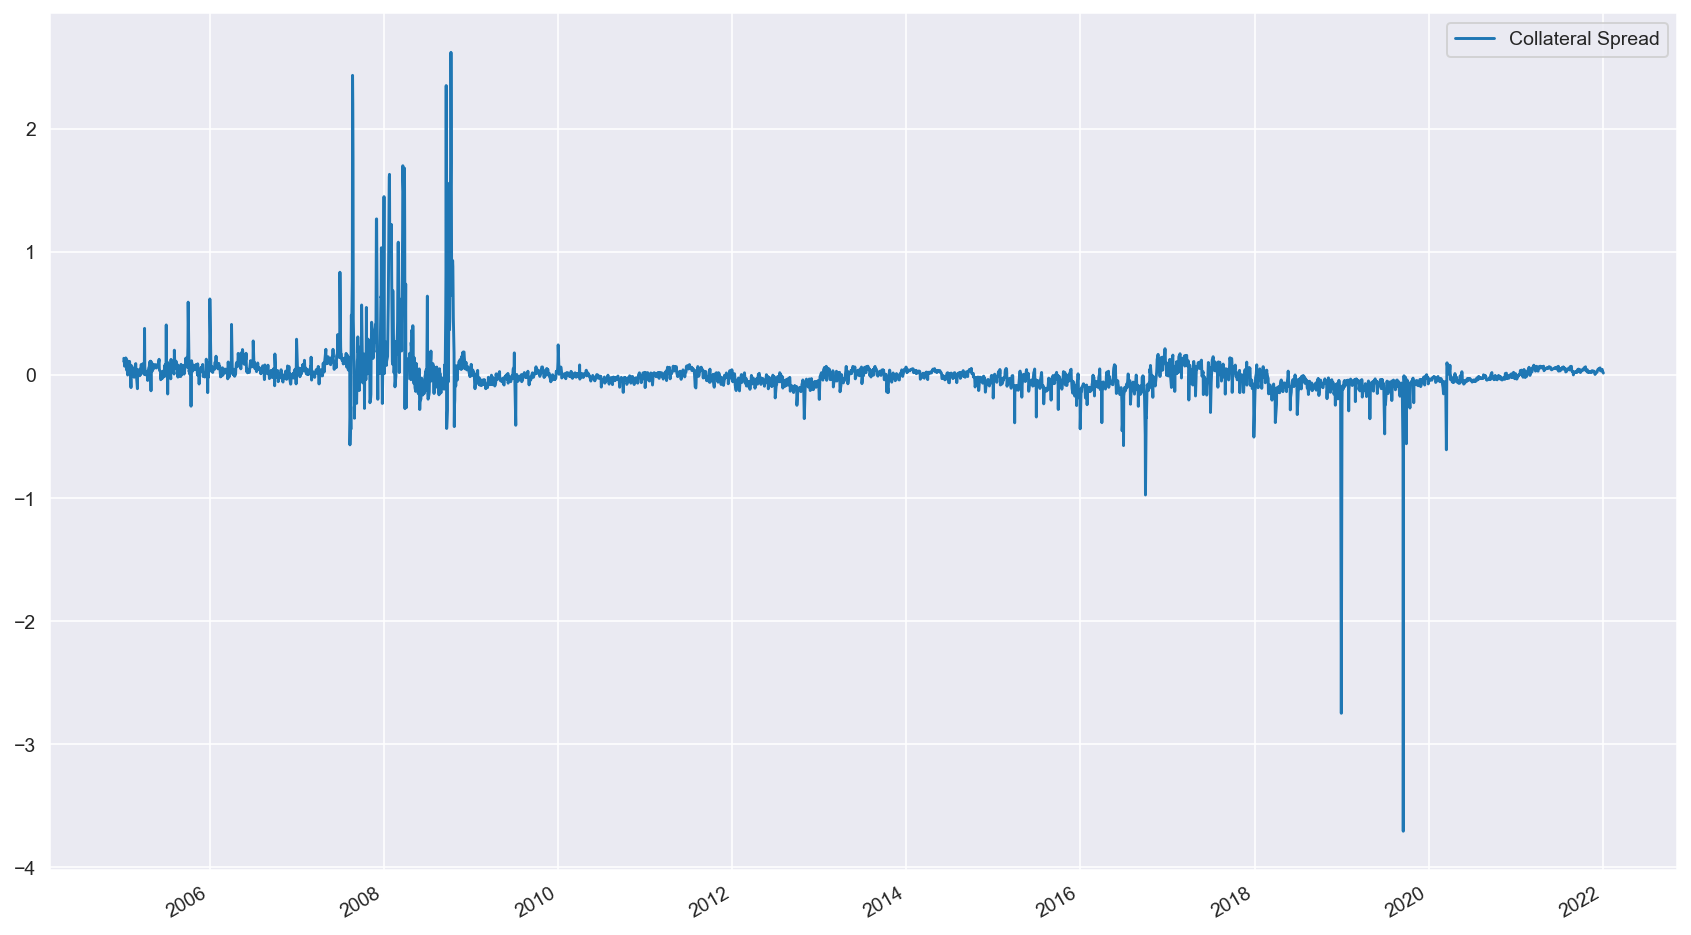

In [202]:
c_spread.iloc[:,-1].plot()
plt.legend(['Collateral Spread'])

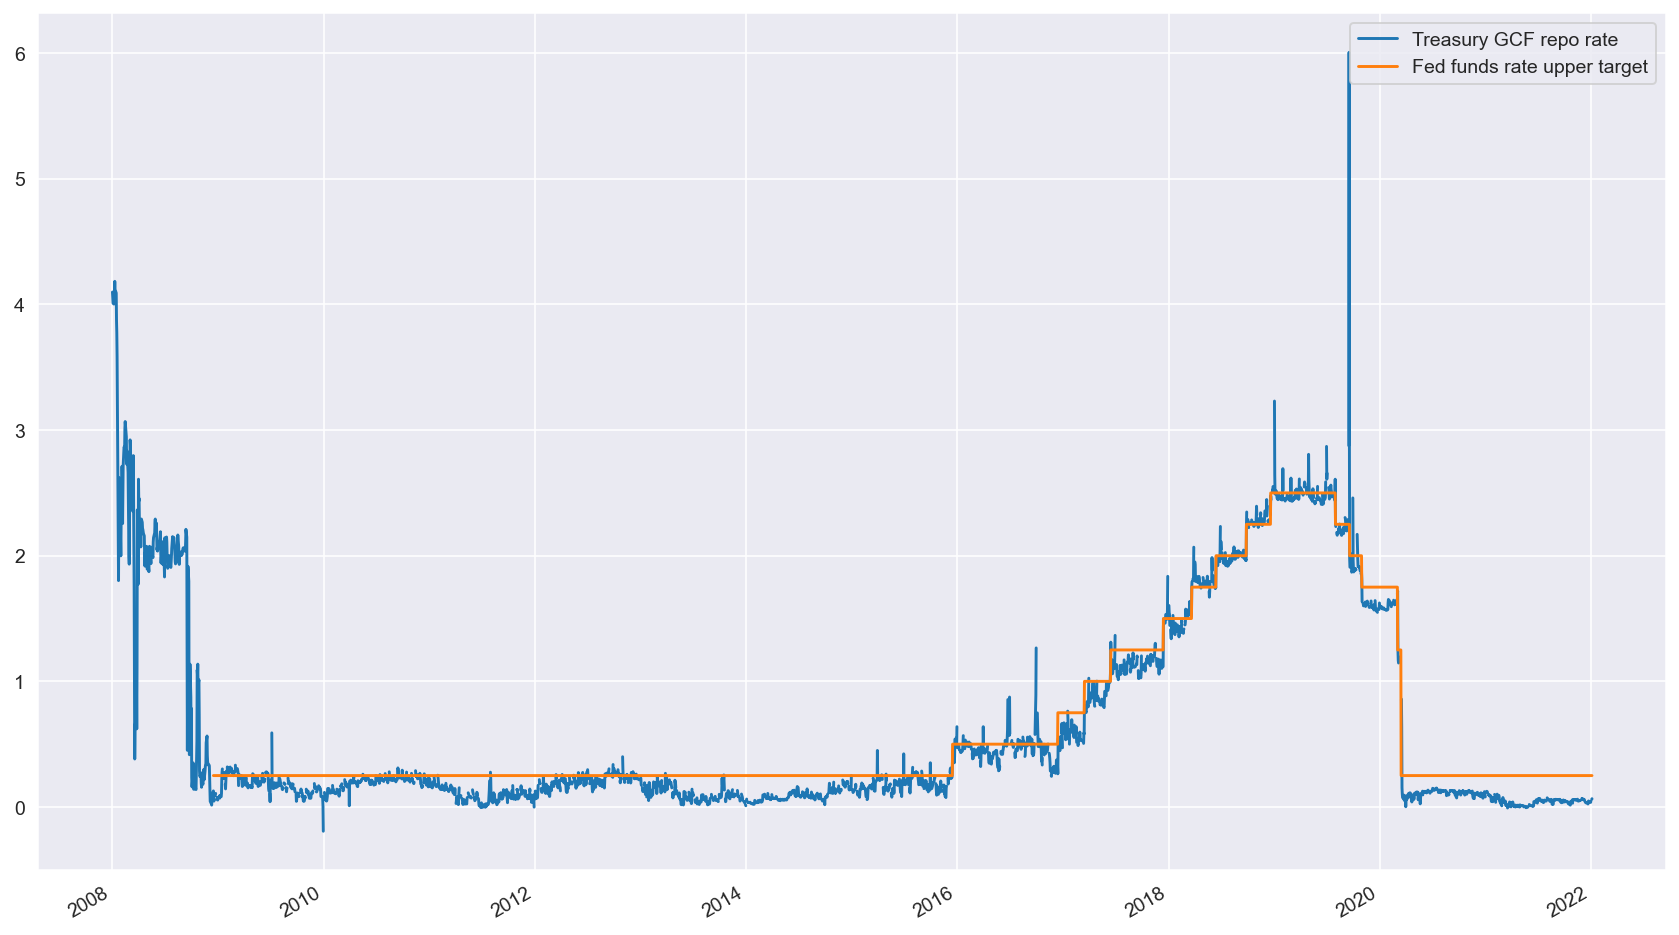

In [201]:
pd.concat([dtcc,fed_target],axis=1)['2008-01-01':].plot()
plt.legend(['Treasury GCF repo rate','Fed funds rate upper target'])

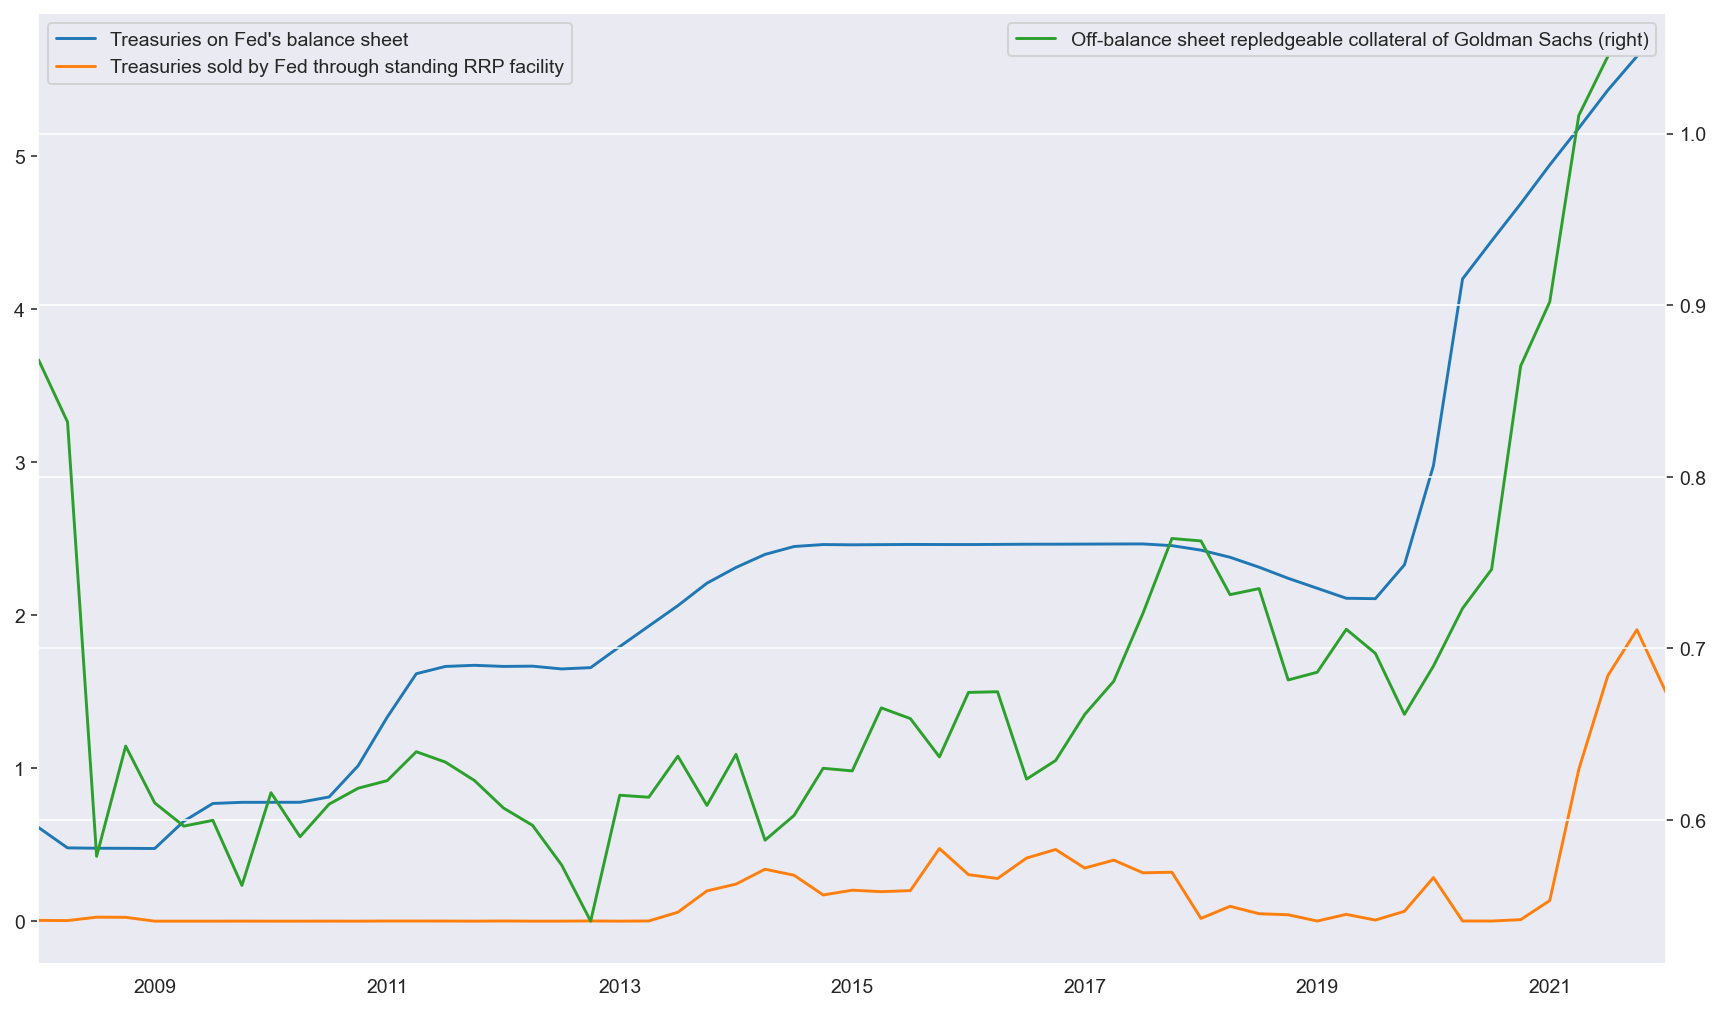

In [194]:
ax = df1_Q.iloc[:,1:3].plot()
ax2 =df1_Q.iloc[:,3:4].plot(secondary_y=True,ax=ax)
ax.legend(['Treasuries on Fed\'s balance sheet',
           'Treasuries sold by Fed through standing RRP facility'])
ax2.legend(['Off-balance sheet repledgeable collateral of Goldman Sachs (right)'],loc=1,)

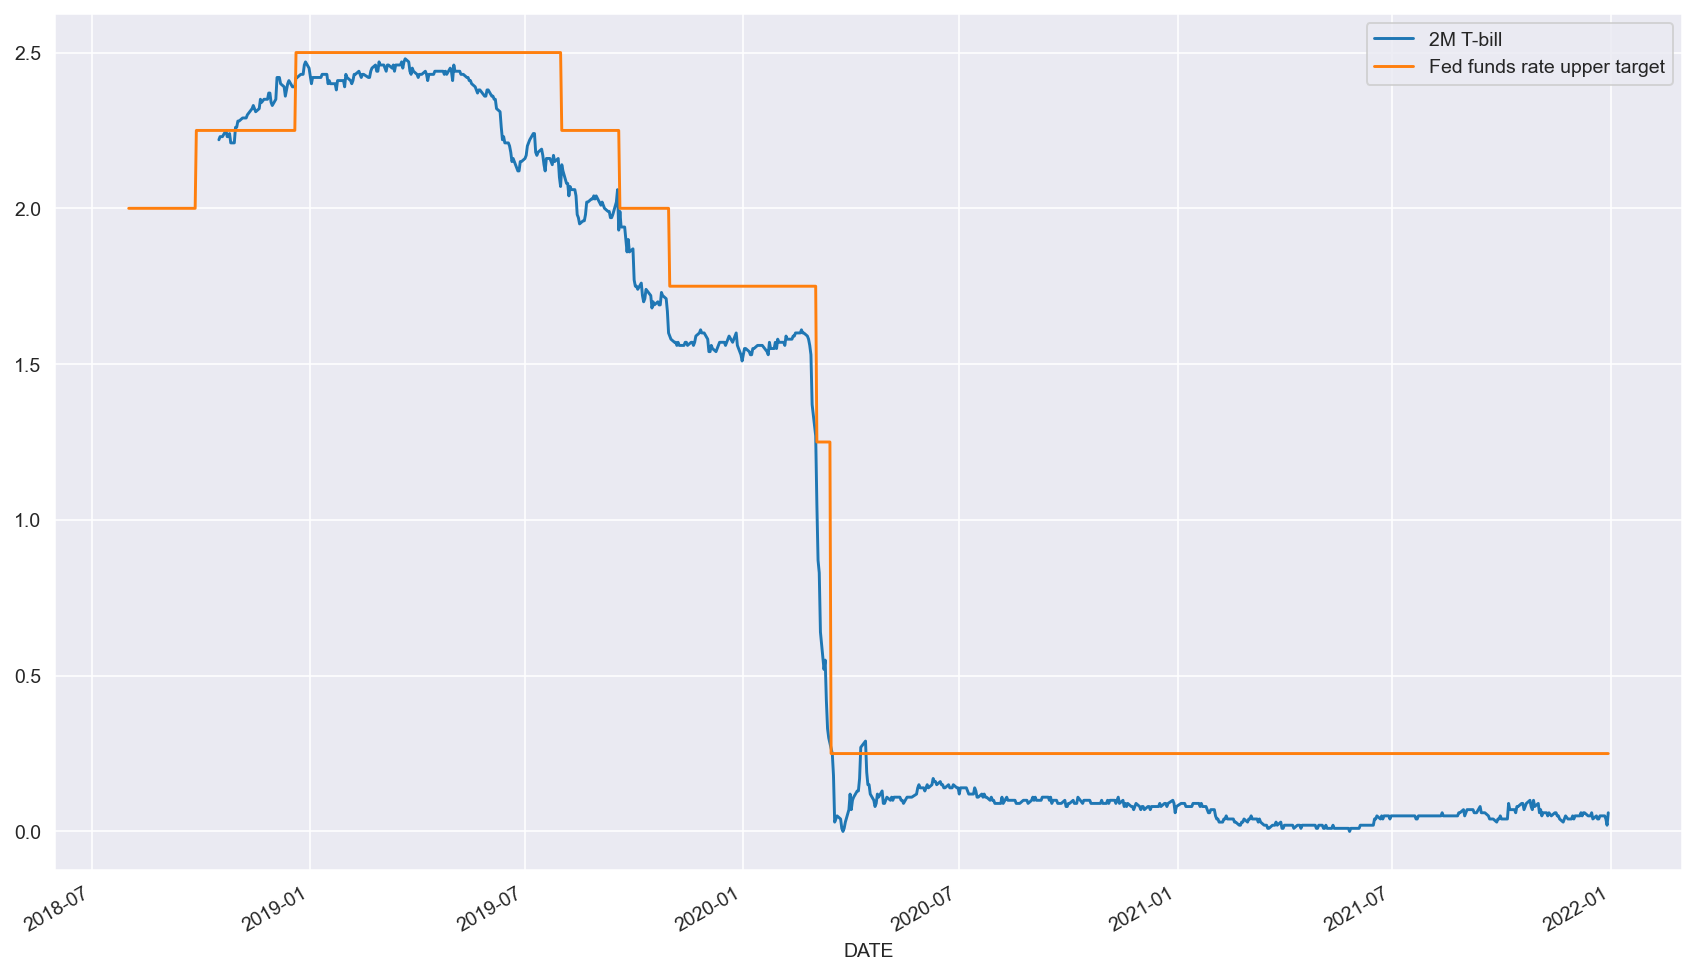

In [200]:
ax = bills['2 MO']['01-06-2018':'30-12-2021'].plot()
fed_target['08-01-2018':'30-12-2021'].plot(ax=ax)
plt.legend(['2M T-bill','Fed funds rate upper target'])

### 2021

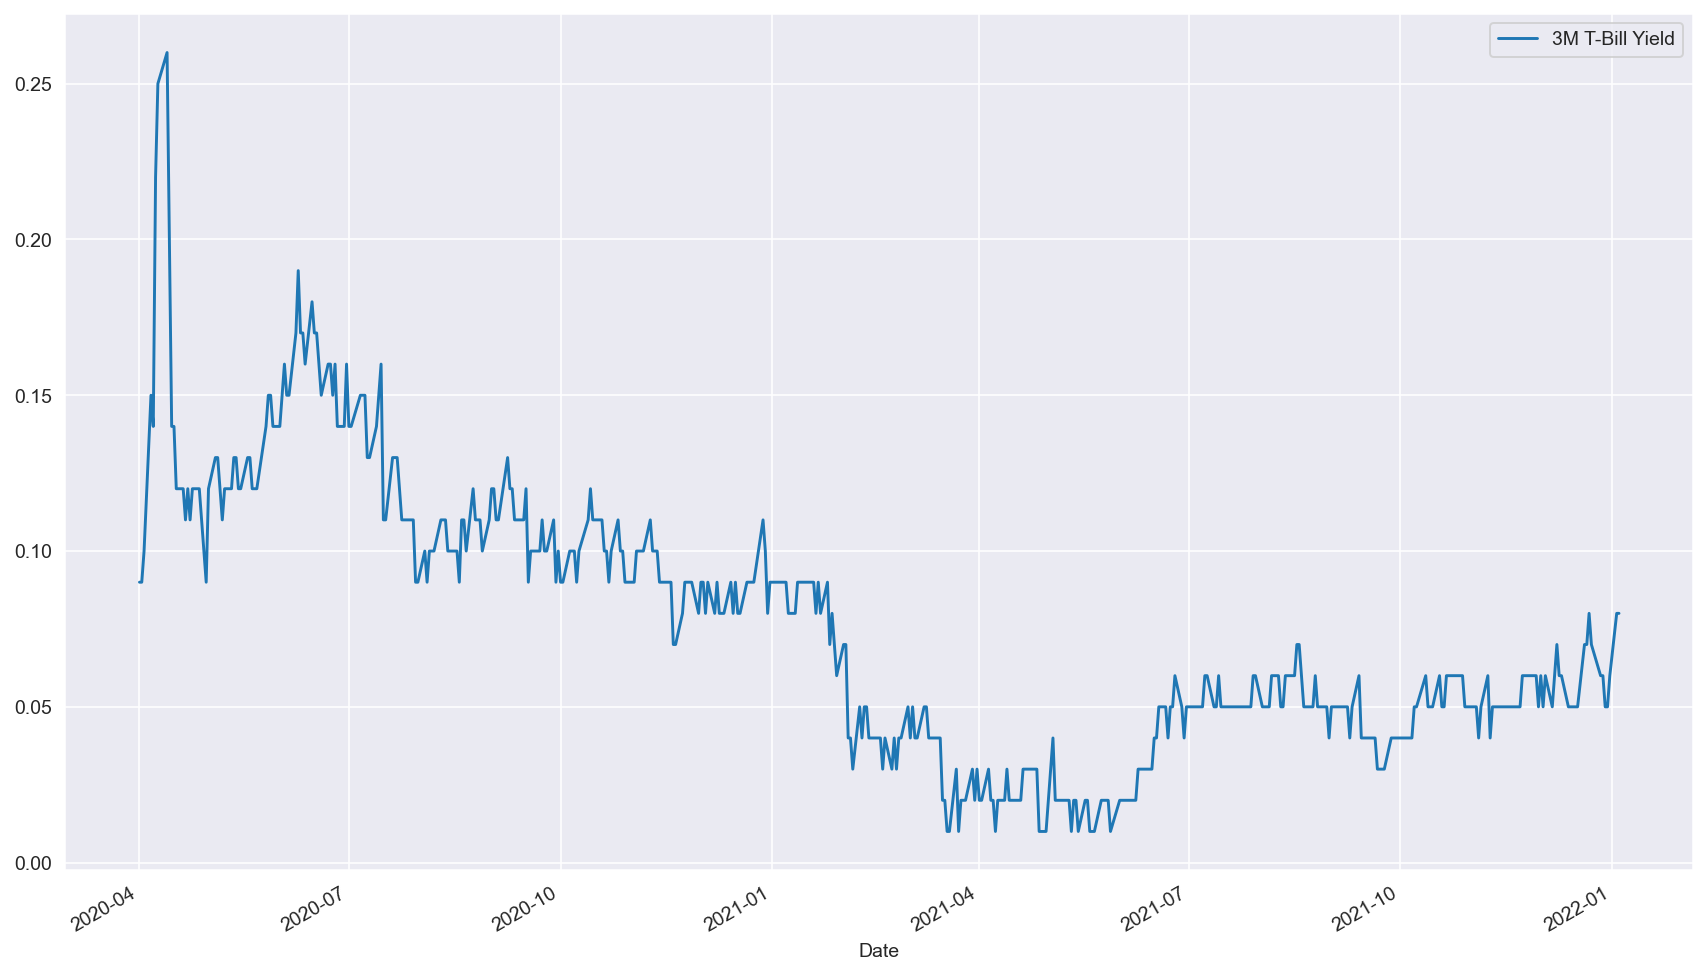

In [163]:
ax = bills['3 MO']['2020-04-01':].plot()
ax.legend(['3M T-Bill Yield'])

<AxesSubplot:xlabel='Date'>

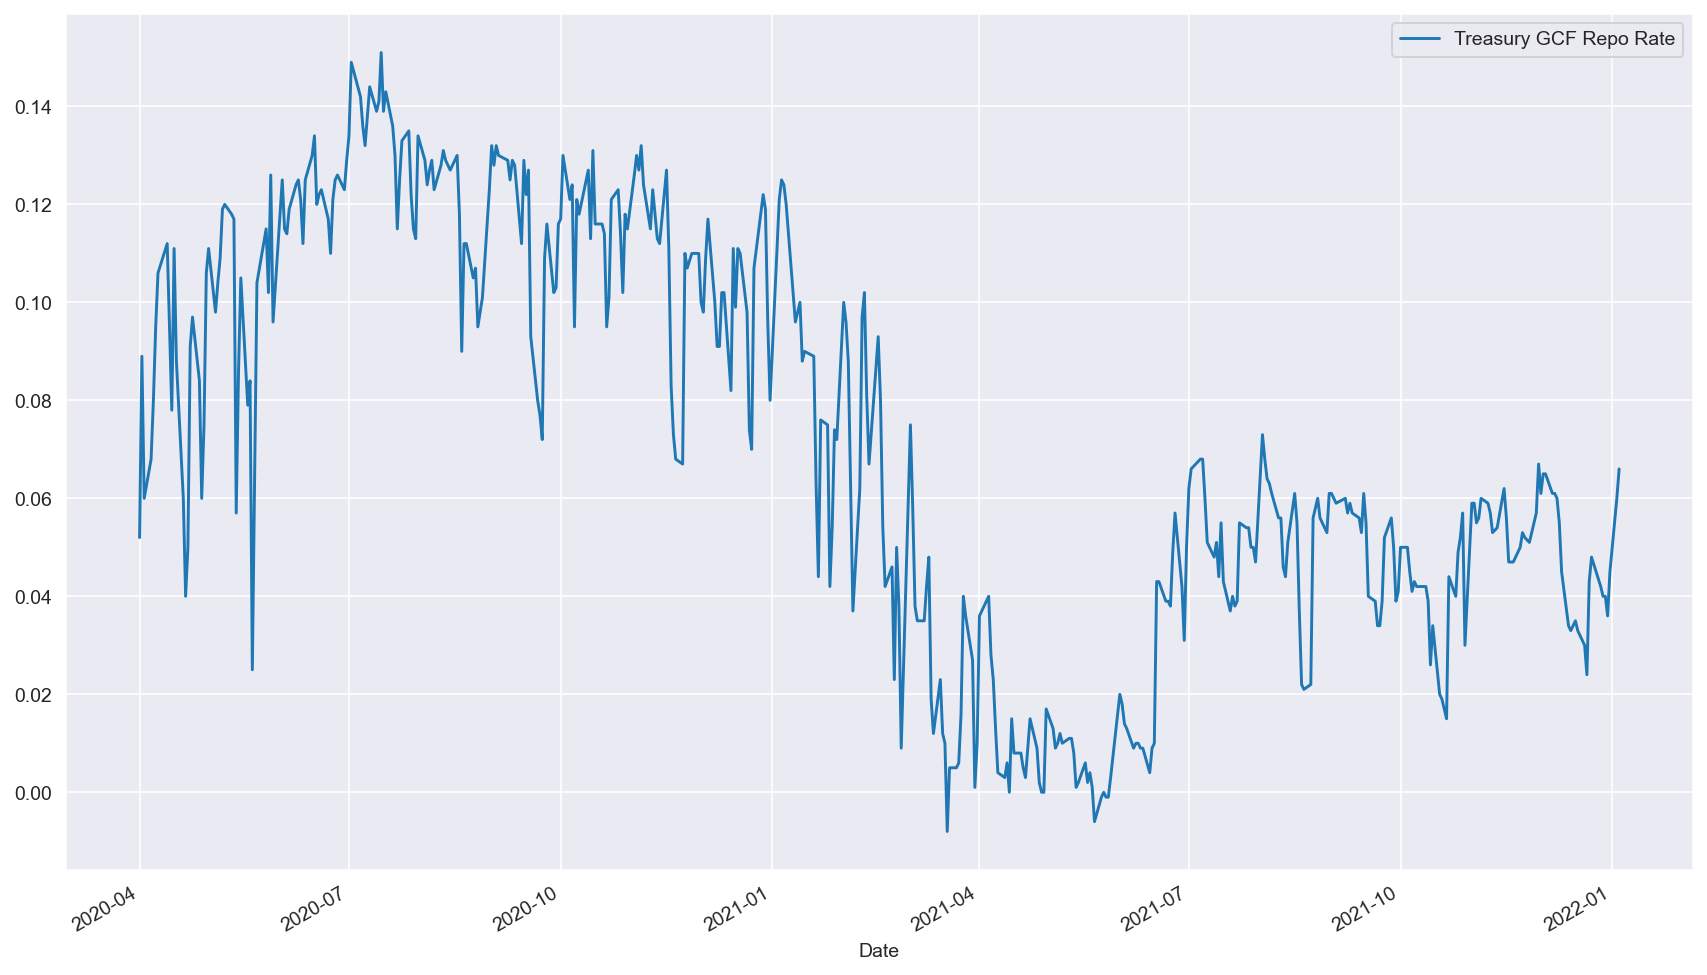

In [164]:
dtcc['2020-04-01':].plot()

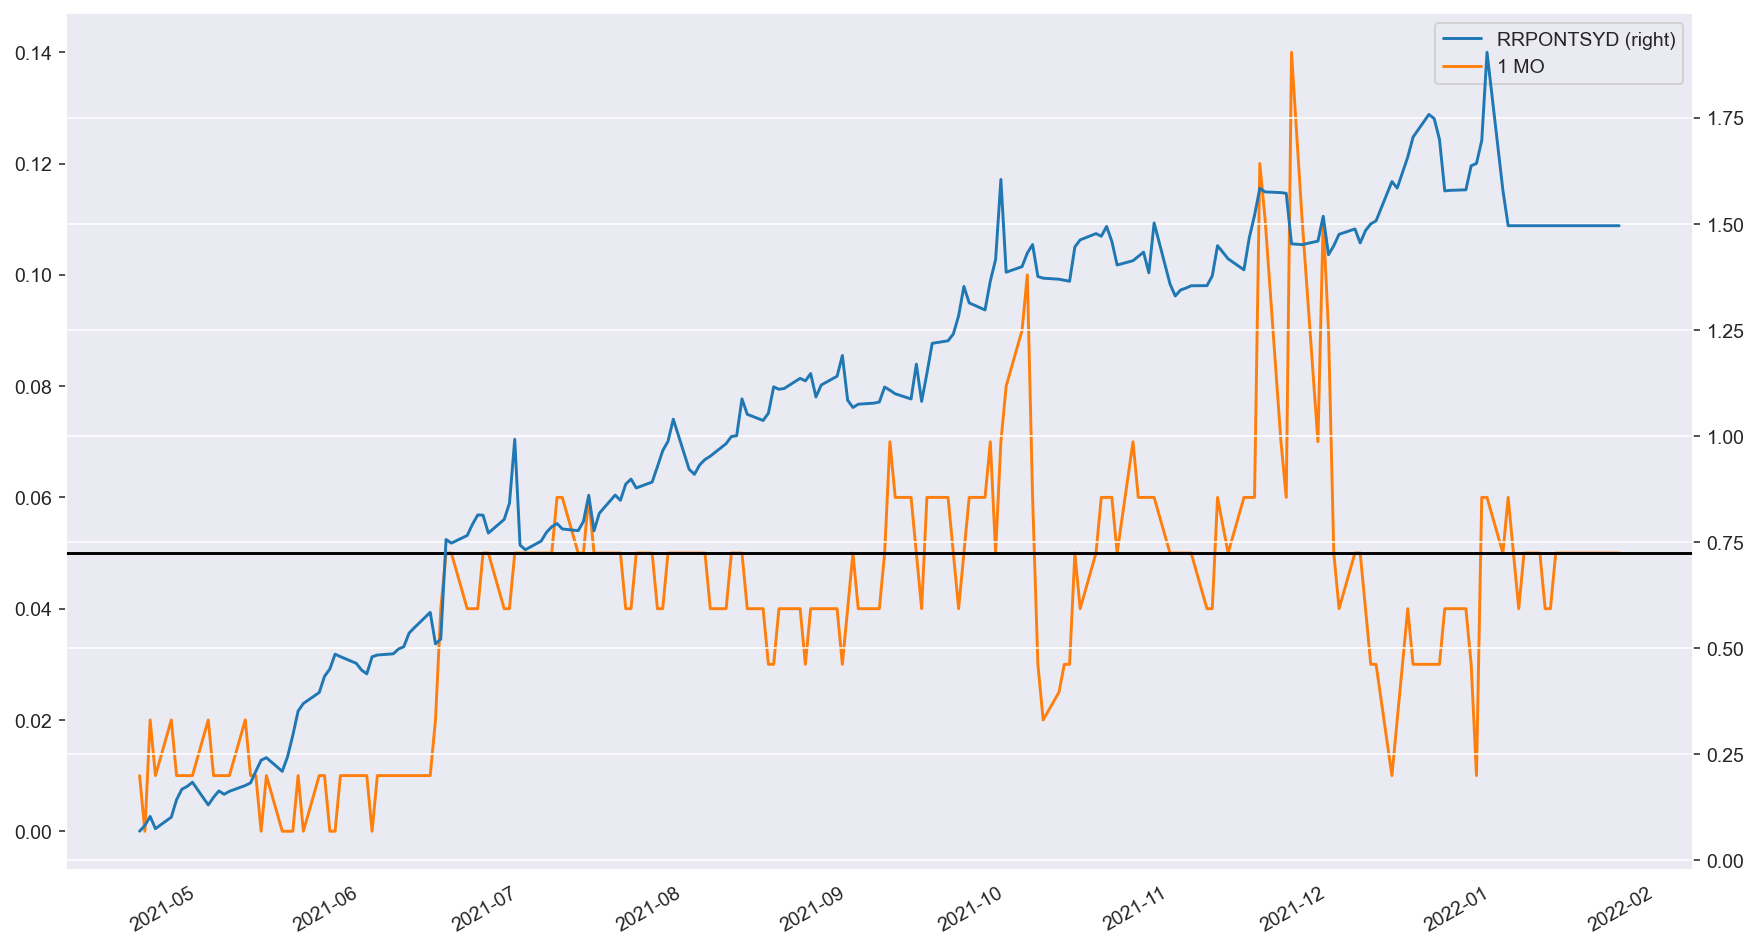

In [177]:
ax1 = pd.concat([rrp,ust],axis=1).iloc[-200:,:2].interpolate().plot(secondary_y='RRPONTSYD')
ax1.axhline(0.05,color='k')

In [ ]:
# ax2 = pd.concat([rrp,ust],axis=1).iloc[-200:,:5].interpolate().plot(secondary_y='RRPONTSYD')
# ax2.axhline(0.05,color='k')